# **03_Modelling and Evaluating**

## Objectives

**Provide ability to answer business requirement 2**

* The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.


## Inputs

* inputs/dataset/cherry_leaves_dataset/cherry-leaves/test
* inputs/dataset/cherry_leaves_dataset/cherry-leaves/train
* inputs/dataset/cherry_leaves_dataset/cherry-leaves/validation
* image shape embeddings


## Outputs

* create ability to answer for Business Requirements 2
* create plot for image distribution in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save the model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file



---

# Set Data Directory

### Import libraries

In [10]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Set working directory

Change the working directory from its current folder to its parent folder
> access the current directory with ```os.getcwd()```

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-mildew-detection/jupyter_notebooks'

Make the parent of the current directory the new current directory
> ```os.path.dirname()``` gets the parent directory; ```os.chir()``` defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-mildew-detection'

### Set input directories

Set train, validation an test paths.

In [5]:
my_data_dir = 'inputs/dataset/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [8]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


### Set image shape

In [11]:
# Import saved image shape embedding
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Count numbers of images in train, test and validation data and display them in a chart

#### Bar Chart

First we count the number of images in each label, show and save them in a bar chart.


* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




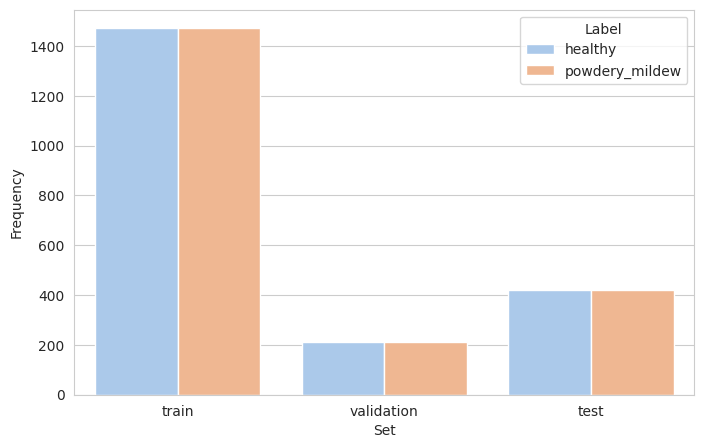

In [ ]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 

# Create an empty dictionary
data_dict = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
image_folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for image_folder in image_folders:
    for label in labels:
        row = {
            'Set': image_folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + image_folder + '/' + label)))  
        }
        for key, value in row.items():
            data_dict[key].append(value)
        print(
            f"* {image_folder} - {label}: {len(os.listdir(my_data_dir+'/'+ image_folder + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data_dict)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette='pastel')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

#### Pie Chart

Again we count the number of images in each label to check if the next part of code uses the correct data, show and save them in a pie chart.

Unlike the previous bar chart this pie chart only shows the total image distributioj between train-, validation- and test sets.

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images


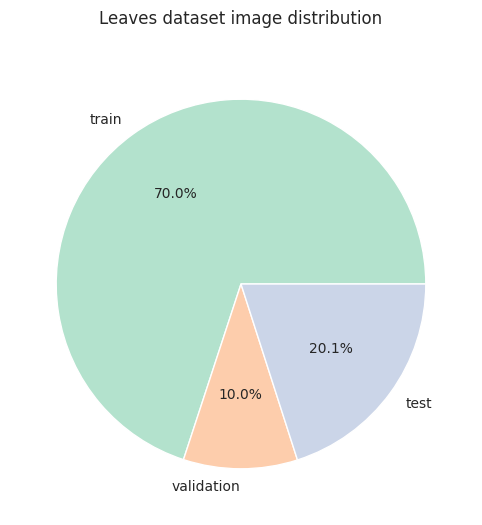

In [ ]:
# looked up other students projects to be able to subdivide each set
# into healthy and mildew infected parts, nothing so far & everything else I tried was buggy

image_folders = ['train', 'validation', 'test']
data_list=[]
for image_folder in image_folders:
    for label in labels:
        n=int(len(os.listdir(my_data_dir + '/' + image_folder + '/' + label)))
        n+=n
        print(
            f"* {image_folder} - {label}: {len(os.listdir(my_data_dir+'/'+ image_folder + '/' + label))} images")
    data_list.append(n)


px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(12,6))
plt.pie(data_list, labels = image_folders, colors = plt.cm.Pastel2.colors, autopct='%.1f%%')
plt.title(f'Leaves dataset image distribution\n')
plt.savefig(f'{file_path}/image_distribution_piechart.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
